In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [3]:
users = pd.read_csv("users.csv")
events = pd.read_csv("events.csv")

users["signup_date"] = pd.to_datetime(users["signup_date"])
events["event_time"] = pd.to_datetime(events["event_time"])

users.head()

,user_id,signup_date,device,country,acquisition_channel
0,U0001,2025-02-21,Web,Canada,Organic
1,U0002,2025-01-15,iOS,US,Ads
2,U0003,2025-03-13,iOS,UK,Organic
3,U0004,2025-03-02,Android,Canada,Organic
4,U0005,2025-01-21,Android,UK,Ads


In [4]:
events.head()


,event_id,user_id,event_time,event_name,order_value
0,E0001,U0001,2025-01-29,login,NaN
1,E0002,U0001,2025-04-08,purchase,11.87
2,E0003,U0001,2025-04-08,browse,NaN
3,E0004,U0002,2025-04-29,browse,NaN
4,E0005,U0002,2025-01-05,purchase,115.72


In [5]:
print(users.dtypes)
print(events.dtypes)

print("Unique users:", users["user_id"].nunique())
print("Unique events:", events["event_id"].nunique())

events["event_id"].head(10)



user_id                        object
signup_date            datetime64[ns]
device                         object
country                        object
acquisition_channel            object
dtype: object
event_id               object
user_id                object
event_time     datetime64[ns]
event_name             object
order_value           float64
dtype: object
Unique users: 1000
Unique events: 5368


0    E0001
1    E0002
2    E0003
3    E0004
4    E0005
5    E0006
6    E0007
7    E0008
8    E0009
9    E0010
Name: event_id, dtype: object

In [6]:
feature_users = events[events["event_name"] == "feature_used"]

adopters = feature_users["user_id"].nunique()
total_users = users["user_id"].nunique()

adoption_rate = adopters / total_users

print("Adopters:", adopters)
print("Total Users:", total_users)
print("Adoption Rate:", round(adoption_rate * 100, 2), "%")


Adopters: 414
Total Users: 1000
Adoption Rate: 41.4 %


In [7]:
purchases = events[events["event_name"] == "purchase"].copy()

total_revenue = purchases["order_value"].sum()
num_purchases = purchases.shape[0]
paying_users = purchases["user_id"].nunique()
arpu = total_revenue / total_users
arppu = total_revenue / paying_users

print("Total revenue:", round(total_revenue, 2))
print("Number of purchases:", num_purchases)
print("Paying users:", paying_users)
print("ARPU (revenue per user):", round(arpu, 2))
print("ARPPU (revenue per paying user):", round(arppu, 2))


Total revenue: 101859.37
Number of purchases: 1666
Paying users: 830
ARPU (revenue per user): 101.86
ARPPU (revenue per paying user): 122.72


In [8]:
adopter_ids = set(feature_users["user_id"].unique())

events["is_adopter"] = events["user_id"].isin(adopter_ids)

purchases = events[events["event_name"] == "purchase"].copy()

rev_by_group = (
    purchases.groupby("is_adopter")["order_value"]
    .agg(total_revenue="sum", avg_order_value="mean", purchases="count")
    .reset_index()
)

rev_by_group["group"] = rev_by_group["is_adopter"].map(
    {True: "Adopters", False: "Non-adopters"}
)

rev_by_group[["group", "total_revenue", "avg_order_value", "purchases"]]


,group,total_revenue,avg_order_value,purchases
0,Non-adopters,58894.58,60.841508,968
1,Adopters,42964.79,61.554140,698


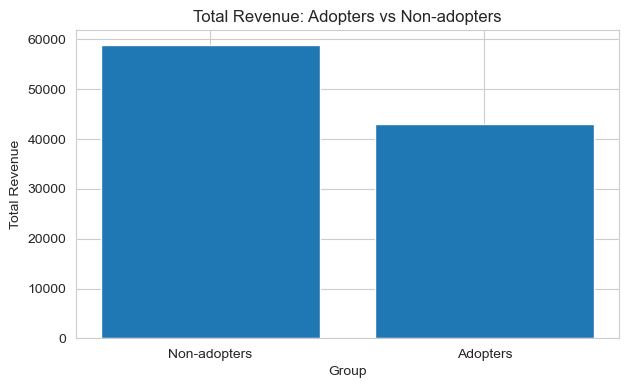

In [9]:
plt.figure(figsize=(7, 4))
plt.bar(rev_by_group["group"], rev_by_group["total_revenue"])
plt.title("Total Revenue: Adopters vs Non-adopters")
plt.xlabel("Group")
plt.ylabel("Total Revenue")
plt.show()

In [10]:
first_adoption = (
    feature_users
    .sort_values("event_time")
    .groupby("user_id")["event_time"]
    .first()
    .reset_index()
)

first_adoption.head()


,user_id,event_time
0,U0002,2025-04-10
1,U0003,2025-04-04
2,U0004,2025-03-31
3,U0006,2025-04-12
4,U0008,2025-03-31


In [11]:
adoption_trend = (
    first_adoption
    .groupby("event_time")
    .size()
    .reset_index(name="new_adopters")
)

adoption_trend.head()


,event_time,new_adopters
0,2025-03-15,12
1,2025-03-16,8
2,2025-03-17,9
3,2025-03-18,14
4,2025-03-19,9


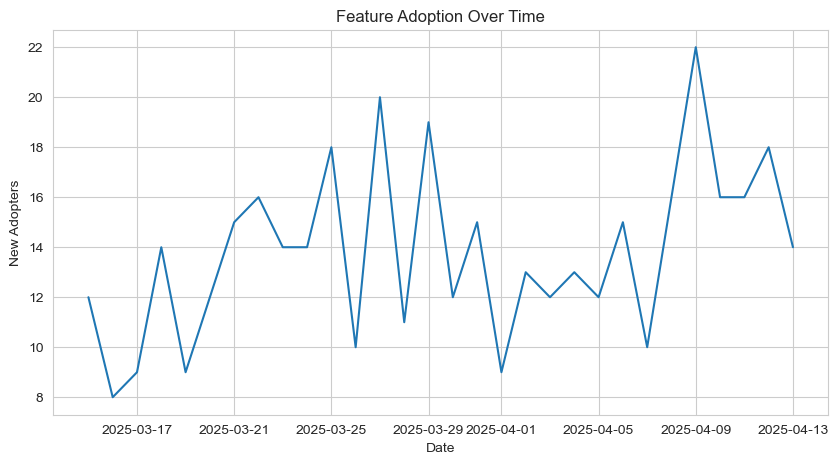

In [12]:
plt.figure(figsize=(10, 5))

plt.plot(
    adoption_trend["event_time"],
    adoption_trend["new_adopters"]
)

plt.title("Feature Adoption Over Time")
plt.xlabel("Date")
plt.ylabel("New Adopters")

plt.show()


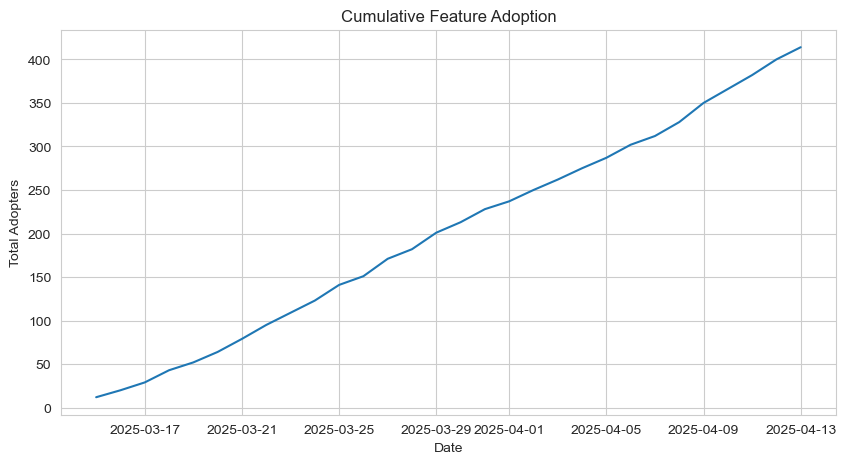

In [13]:
adoption_trend["cumulative_adopters"] = adoption_trend["new_adopters"].cumsum()

plt.figure(figsize=(10, 5))

plt.plot(
    adoption_trend["event_time"],
    adoption_trend["cumulative_adopters"]
)

plt.title("Cumulative Feature Adoption")
plt.xlabel("Date")
plt.ylabel("Total Adopters")

plt.show()


In [14]:
adoption_with_users = first_adoption.merge(
    users,
    on="user_id",
    how="left"
)

adoption_with_users.head()


,user_id,event_time,signup_date,device,country,acquisition_channel
0,U0002,2025-04-10,2025-01-15,iOS,US,Ads
1,U0003,2025-04-04,2025-03-13,iOS,UK,Organic
2,U0004,2025-03-31,2025-03-02,Android,Canada,Organic
3,U0006,2025-04-12,2025-03-24,Web,UK,Ads
4,U0008,2025-03-31,2025-03-16,iOS,Canada,Ads


In [15]:
device_adoption = (
    adoption_with_users
    .groupby("device")["user_id"]
    .nunique()
    .reset_index(name="adopters")
)

device_adoption


,device,adopters
0,Android,150
1,Web,141
2,iOS,123


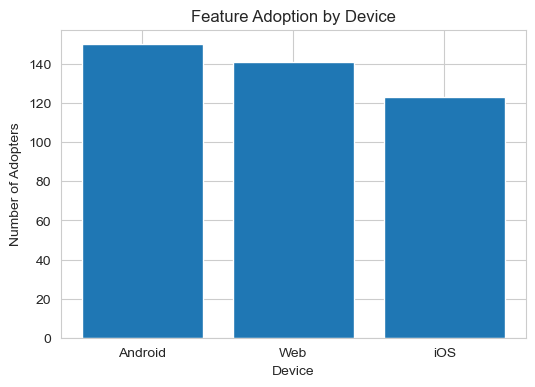

In [16]:
plt.figure(figsize=(6,4))

plt.bar(device_adoption["device"], device_adoption["adopters"])

plt.title("Feature Adoption by Device")
plt.xlabel("Device")
plt.ylabel("Number of Adopters")

plt.show()


In [17]:
users_per_device = (
    users
    .groupby("device")["user_id"]
    .nunique()
    .reset_index(name="total_users")
)

users_per_device


,device,total_users
0,Android,335
1,Web,330
2,iOS,335


In [18]:
device_adoption_rate = device_adoption.merge(
    users_per_device,
    on="device"
)

device_adoption_rate["adoption_rate"] = (
    device_adoption_rate["adopters"]
    / device_adoption_rate["total_users"]
)

device_adoption_rate


,device,adopters,total_users,adoption_rate
0,Android,150,335,0.447761
1,Web,141,330,0.427273
2,iOS,123,335,0.367164


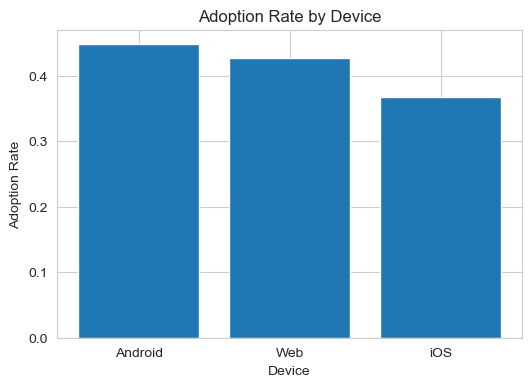

In [19]:
plt.figure(figsize=(6,4))

plt.bar(
    device_adoption_rate["device"],
    device_adoption_rate["adoption_rate"]
)

plt.title("Adoption Rate by Device")
plt.xlabel("Device")
plt.ylabel("Adoption Rate")

plt.show()


In [22]:
feature_launch_date = pd.to_datetime("2025-03-15")

first_adoption["days_after_launch"] = (
    first_adoption["event_time"] - feature_launch_date
).dt.days

first_adoption.head()

,user_id,event_time,days_after_launch
0,U0002,2025-04-10,26
1,U0003,2025-04-04,20
2,U0004,2025-03-31,16
3,U0006,2025-04-12,28
4,U0008,2025-03-31,16


In [24]:
adoption_with_users = first_adoption.merge(
    users,
    on="user_id",
    how="left"
)

adoption_with_users.head()


,user_id,event_time,days_after_launch,signup_date,device,country,acquisition_channel
0,U0002,2025-04-10,26,2025-01-15,iOS,US,Ads
1,U0003,2025-04-04,20,2025-03-13,iOS,UK,Organic
2,U0004,2025-03-31,16,2025-03-02,Android,Canada,Organic
3,U0006,2025-04-12,28,2025-03-24,Web,UK,Ads
4,U0008,2025-03-31,16,2025-03-16,iOS,Canada,Ads


In [25]:
time_by_device = (
    adoption_with_users
    .groupby("device")["days_after_launch"]
    .agg(["mean", "median"])
    .reset_index()
)

time_by_device


,device,mean,median
0,Android,15.793333,15.5
1,Web,15.007092,15.0
2,iOS,15.097561,15.0


In [26]:
user_events = events.merge(
    users[["user_id", "signup_date"]],
    on="user_id",
    how="left"
)

user_events.head()


,event_id,user_id,event_time,event_name,order_value,is_adopter,signup_date
0,E0001,U0001,2025-01-29,login,NaN,False,2025-02-21
1,E0002,U0001,2025-04-08,purchase,11.87,False,2025-02-21
2,E0003,U0001,2025-04-08,browse,NaN,False,2025-02-21
3,E0004,U0002,2025-04-29,browse,NaN,True,2025-01-15
4,E0005,U0002,2025-01-05,purchase,115.72,True,2025-01-15


In [27]:
user_events["days_since_signup"] = (
    user_events["event_time"] - user_events["signup_date"]
).dt.days

user_events.head()


,event_id,user_id,event_time,event_name,order_value,is_adopter,signup_date,days_since_signup
0,E0001,U0001,2025-01-29,login,NaN,False,2025-02-21,-23
1,E0002,U0001,2025-04-08,purchase,11.87,False,2025-02-21,46
2,E0003,U0001,2025-04-08,browse,NaN,False,2025-02-21,46
3,E0004,U0002,2025-04-29,browse,NaN,True,2025-01-15,104
4,E0005,U0002,2025-01-05,purchase,115.72,True,2025-01-15,-10


In [28]:
retained_users = user_events[
    user_events["days_since_signup"] >= 7
]["user_id"].unique()

len(retained_users)


941

In [29]:
users["is_retained"] = users["user_id"].isin(retained_users)

users.head()


,user_id,signup_date,device,country,acquisition_channel,is_retained
0,U0001,2025-02-21,Web,Canada,Organic,True
1,U0002,2025-01-15,iOS,US,Ads,True
2,U0003,2025-03-13,iOS,UK,Organic,True
3,U0004,2025-03-02,Android,Canada,Organic,True
4,U0005,2025-01-21,Android,UK,Ads,True


In [30]:
adopter_ids = feature_users["user_id"].unique()
users["is_adopter"] = users["user_id"].isin(adopter_ids)

users.head()


,user_id,signup_date,device,country,acquisition_channel,is_retained,is_adopter
0,U0001,2025-02-21,Web,Canada,Organic,True,False
1,U0002,2025-01-15,iOS,US,Ads,True,True
2,U0003,2025-03-13,iOS,UK,Organic,True,True
3,U0004,2025-03-02,Android,Canada,Organic,True,True
4,U0005,2025-01-21,Android,UK,Ads,True,False


In [31]:
retention_by_group = (
    users
    .groupby("is_adopter")["is_retained"]
    .mean()
    .reset_index()
)

retention_by_group["group"] = retention_by_group["is_adopter"].map(
    {True: "Adopters", False: "Non-adopters"}
)

retention_by_group["retention_rate_pct"] = (
    retention_by_group["is_retained"] * 100
)

retention_by_group[["group", "retention_rate_pct"]]


,group,retention_rate_pct
0,Non-adopters,91.126280
1,Adopters,98.309179


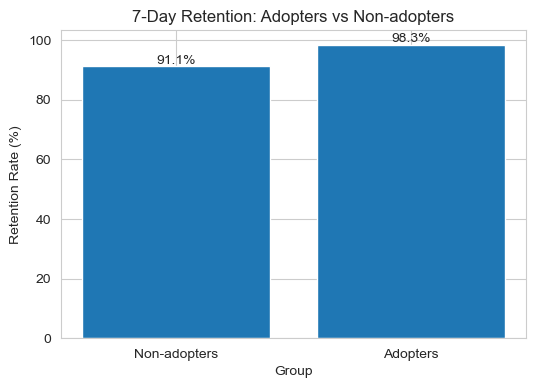

In [32]:
plt.figure(figsize=(6,4))

bars = plt.bar(
    retention_by_group["group"],
    retention_by_group["retention_rate_pct"]
)

plt.title("7-Day Retention: Adopters vs Non-adopters")
plt.xlabel("Group")
plt.ylabel("Retention Rate (%)")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

plt.show()